# A short demo on the Wavelet Detection Filter

We present here a brief example of usage of WDF for gravitational wave data analysis. WDF uses the pytsa (a python embedding for p4TSA) library for data preprocessing and searches for burst signals with a wavelet based method. Let's import some useful libraries:

In [1]:
import time
import os
import sys
from tempfile import NamedTemporaryFile
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import *
from wdf.processes.wdfUnitDSWorker import * 
from glob import glob
import json
import logging
import coloredlogs
coloredlogs.install(isatty=True)

%matplotlib inline

In [2]:
os.getcwd()

'/users/iess/GlitchClassification/notebooks'

Importing script from my project repository:

In [3]:
sys.path.append("../scripts")
import segments
import get_git_repo_root

In [4]:
segments.get_list()

[[1387467863.0, 1387467880.0],
 [1387467881.0, 1387468287.0],
 [1387470702.0, 1387497578.0],
 [1387500782.0, 1387511647.0],
 [1387513848.0, 1387609426.0],
 [1387622727.0, 1387637112.0],
 [1387642884.0, 1387678155.0],
 [1387682595.0, 1387696797.0],
 [1387697813.0, 1387706314.0],
 [1387721669.0, 1387725556.0],
 [1387725557.0, 1387743818.0],
 [1387745979.0, 1387783246.0],
 [1387783251.0, 1387783261.0],
 [1387783578.0, 1387787623.0],
 [1387813009.0, 1387868651.0],
 [1387869096.0, 1387876632.0],
 [1387906766.0, 1387931885.0],
 [1387940620.0, 1387954830.0],
 [1387981273.0, 1388004383.0],
 [1388006803.0, 1388039590.0],
 [1388042024.0, 1388043028.0],
 [1388050432.0, 1388062029.0],
 [1388062271.0, 1388063982.0],
 [1388069932.0, 1388129020.0]]

When launching WDF, we supply a number of parameters and configuration options. These parameters are loaded into WDF from a dictionary in a JSON configuration file.

In [26]:
results_dir = os.path.join(get_git_repo_root.repo_root(), 'results')
ffl_list = '/virgoData/ffl/raw.ffl'

configuration = {
   "sampling": 16384,
   "window": 512,                     # 512 --> wavelet window after resampling is 0.25 seconds
   "overlap": 128,                    # overlap between adjacent wavelet windows
   "threshold": 0.3,                  # stay between 0.2 and 0.5
   "len": 10.0,                       # length of data loaded in WDF loop at each iteration
   "ResamplingFactor":8,              # 16kHz---> 2kHz 
   "run": "run",                    # Name of the run, don't change
   'ID': 'test',
   'dir': results_dir,
   'file': ffl_list,            # can be the .gwf file or an ffl list of .gwf files 
   'channel': 'V1:Hrec_hoft_16384Hz',   # channel of data, gravitational wave strain from Virgo at 16kHz
   "outdir": results_dir,    # output directory for whitened data, keep same as dir
   "ARorder": 1000,             # Order of the autoregressive model, can set lower for synthetic noise
   "learn": 200,                # number of seconds at beginning of a segment, used to compute AR parameters
                                # check scipy.signal.welch for the welch spectrogram
   'preWhite':3,                    
#   'nproc': 4,
#   'gps': 0.0,                 # if we want to provide gps to start analysis
    'segments': segments.get_list()[0]      # list of segments to analyze
    }                
 
filejson = os.path.join(results_dir,"test_configuration.json")
file_json = open(filejson, "w+")       
json.dump(configuration, file_json)
file_json.close()

print(filejson)

/users/iess/GlitchClassification/results/test_configuration.json


In [27]:
par = Parameters()
par.load(filejson)      
par.print()

{   'ARorder': 1000,
    'ID': 'test',
    'ResamplingFactor': 8,
    'channel': 'V1:Hrec_hoft_16384Hz',
    'dir': '/users/iess/GlitchClassification/results',
    'file': '/virgoData/ffl/raw.ffl',
    'learn': 200,
    'len': 10.0,
    'outdir': '/users/iess/GlitchClassification/results',
    'overlap': 128,
    'preWhite': 3,
    'run': 'run',
    'sampling': 16384,
    'segments': [1387467863.0, 1387467880.0],
    'threshold': 0.3,
    'window': 512}


In [28]:
data = SV()              # define this instance of a sequenceView object 
stream = FrameIChannel(par.file, par.channel, 100.0, par.segments[0]+300)      #

In [29]:
stream.GetData(data)

True

In [30]:
import numpy as np
import matplotlib.pyplot as plt
def plot_SV(data_sv, colour='b'):
    x = np.zeros(data_sv.GetSize())
    y = np.zeros(data_sv.GetSize())
    for i in range(data_sv.GetSize()):
        x[i] = data_sv.GetX(i)
        y[i] = data_sv.GetY(0,i)
    plt.plot(x,y, colour), plt.grid()
    return x, y

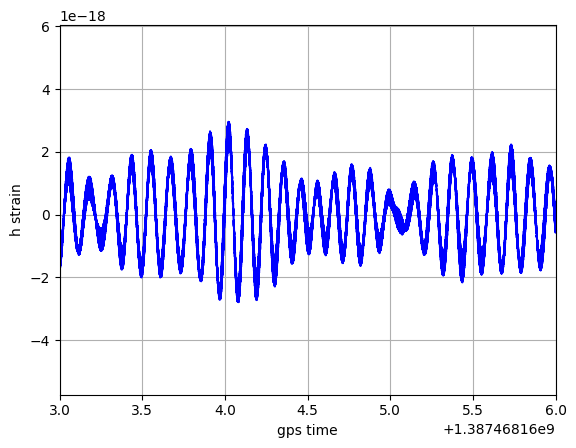

In [43]:
plot_SV(data), plt.xlabel('gps time'), plt.ylabel('h strain'), plt.xlim(par.segments[0]+300, par.segments[0]+303);

In [32]:
data_for_ARest = SV()
AR_est_stream = FrameIChannel(par.file, par.channel, 100.0, par.segments[0])      #
AR_est_stream.GetData(data_for_ARest)

True

In [33]:
from wdf.processes.Whitening import Whitening
from wdf.processes.DWhitening import  DWhitening

In [34]:
whiten = Whitening(par.ARorder)

In [35]:
par.ARfile = os.path.join(results_dir, "ARcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel))
par.LVfile = os.path.join(results_dir, "LVcoeff-AR%s-fs%s-%s.txt" % (
                par.ARorder, par.sampling, par.channel))

whiten.ParametersEstimate(data_for_ARest)
whiten.ParametersSave(par.ARfile, par.LVfile)
print('Parameters saved.')

Parameters saved.


In [ ]:
par.sigma = whiten.GetSigma()
dataw = SV()                     # whitened data
whiten.Process(data, dataw)

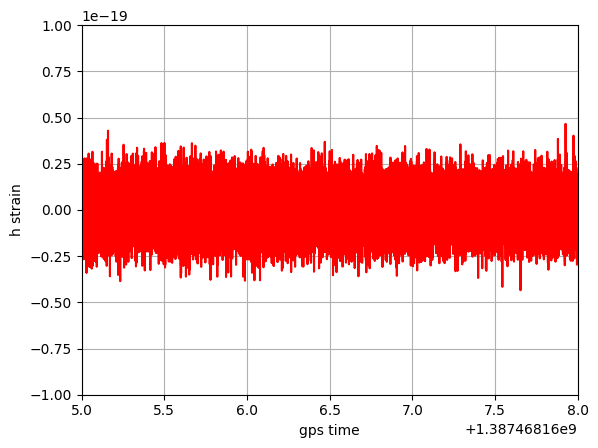

In [46]:
import matplotlib
matplotlib.rcParams['agg.path.chunksize']=10000

plot_SV(dataw, colour='r'), plt.xlabel('gps time'), plt.ylabel('h strain'),
plt.xlim(par.segments[0]+300+2,par.segments[0]+300+5), plt.ylim(-1e-19, 1e-19);